In [5]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../.venv/lib/python3.9/site-packages/')
sys.path.append('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Custom code
from coordination.audio.audio import TrialAudio
from coordination.component.speech.vocalics_component import SegmentationMethod, VocalicsComponent
from coordination.entity.trial import Trial
from coordination.inference.discrete_coordination import DiscreteCoordinationInferenceFromVocalics
from coordination.inference.gaussian_coordination import GaussianCoordinationInferenceFromVocalics
from coordination.inference.logistic_coordination import LogisticCoordinationInferenceFromVocalics
from coordination.inference.beta_coordination import BetaCoordinationInferenceFromVocalics
from coordination.plot.coordination import add_discrete_coordination_bar
from coordination.report.coordination_change_report import CoordinationChangeReport

# Trial 745

We use post processed trial data. To generate this data, execute the script `coordination/scripts/parse_and_save_single_metadata_file.py`.

In [7]:
# Constants
NUM_TIME_STEPS = 17 * 60 #(17 minutes of mission in seconds)
M = int(NUM_TIME_STEPS/2) # We assume coordination in the second half of the period is constant
NUM_FEATURES = 2 # Pitch and Intensity

# Common parameters
MEAN_PRIOR_VOCALICS = np.zeros(NUM_FEATURES)
STD_PRIOR_VOCALICS = np.ones(NUM_FEATURES)
STD_COORDINATED_VOCALICS = np.ones(NUM_FEATURES)
ANTIPHASE_FUNCTION = lambda x, s: -x if s == 0 else x
EITHER_PHASE_FUNCTION = lambda x, s: np.abs(x)

# Parameters of the discrete model
P_COORDINATION_TRANSITION = 0.1 # Coordination changes with small probability
P_COORDINATION = 0 # The process starts with no coordination
STD_UNCOORDINATED_VOCALICS = np.ones(NUM_FEATURES)

# Parameters of the Gaussian model
MEAN_COORDINATION_PRIOR = 0; STD_COORDINATION_PRIOR = 0 # The process starts with no coordination
STD_COORDINATION_DRIFT = 0.1 # Coordination drifts by a little

# Parameters of the Beta model
A0 = 1E-16; B0 = 1E16 # The process starts with no coordination

## Vocalic Features

Utterance starting at 2022-06-14T22:43:54.542990+00:00 and ending 
                    at 2022-06-14T22:43:54.354299+00:00 is short and does not have any vocalics. Text:  all right
Utterance starting at 2022-06-14T22:51:21.956330+00:00 and ending 
                    at 2022-06-14T22:51:21.595633+00:00 is short and does not have any vocalics. Text:  okay
Utterance starting at 2022-06-14T22:50:47.542990+00:00 and ending 
                    at 2022-06-14T22:50:47.554299+00:00 is short and does not have any vocalics. Text:  yes you are


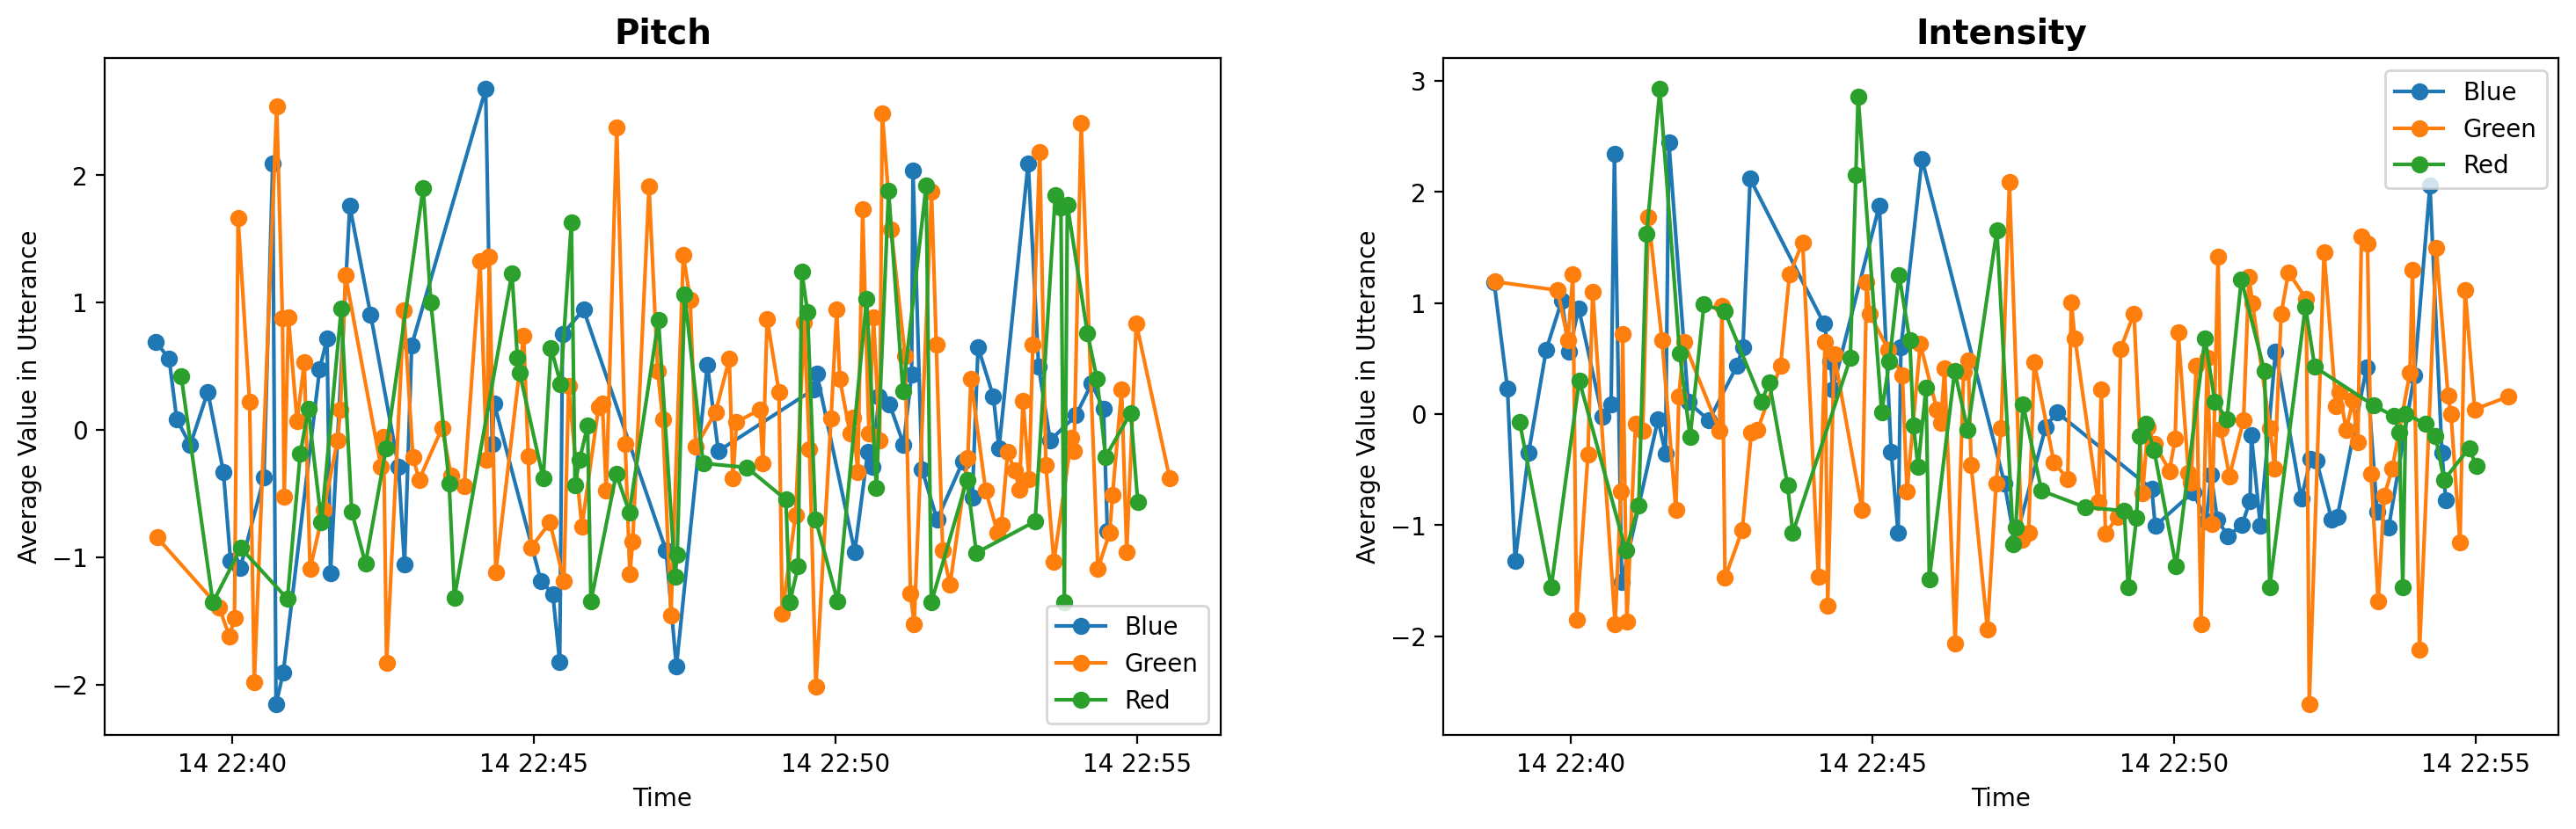

In [9]:
trial = Trial.from_directory("../data/study-3_2022/tomcat_agent/trials/T000745/")
vocalics_component = VocalicsComponent.from_vocalics(trial.vocalics, 
                                                     segmentation_method=SegmentationMethod.KEEP_ALL)

vocalic_series = vocalics_component.sparse_series(NUM_TIME_STEPS, trial.metadata.mission_start)
vocalic_series.normalize_per_subject()

fig, axs = plt.subplots(1, 2, figsize=(18,5))
vocalics_component.plot_features(axs=axs, 
                                 num_time_steps=1020, 
                                 mission_start=trial.metadata.mission_start,
                                 timestamp_as_index=True, 
                                 normalize=True)

## Discrete Coordination Inference

### Phase Coordination

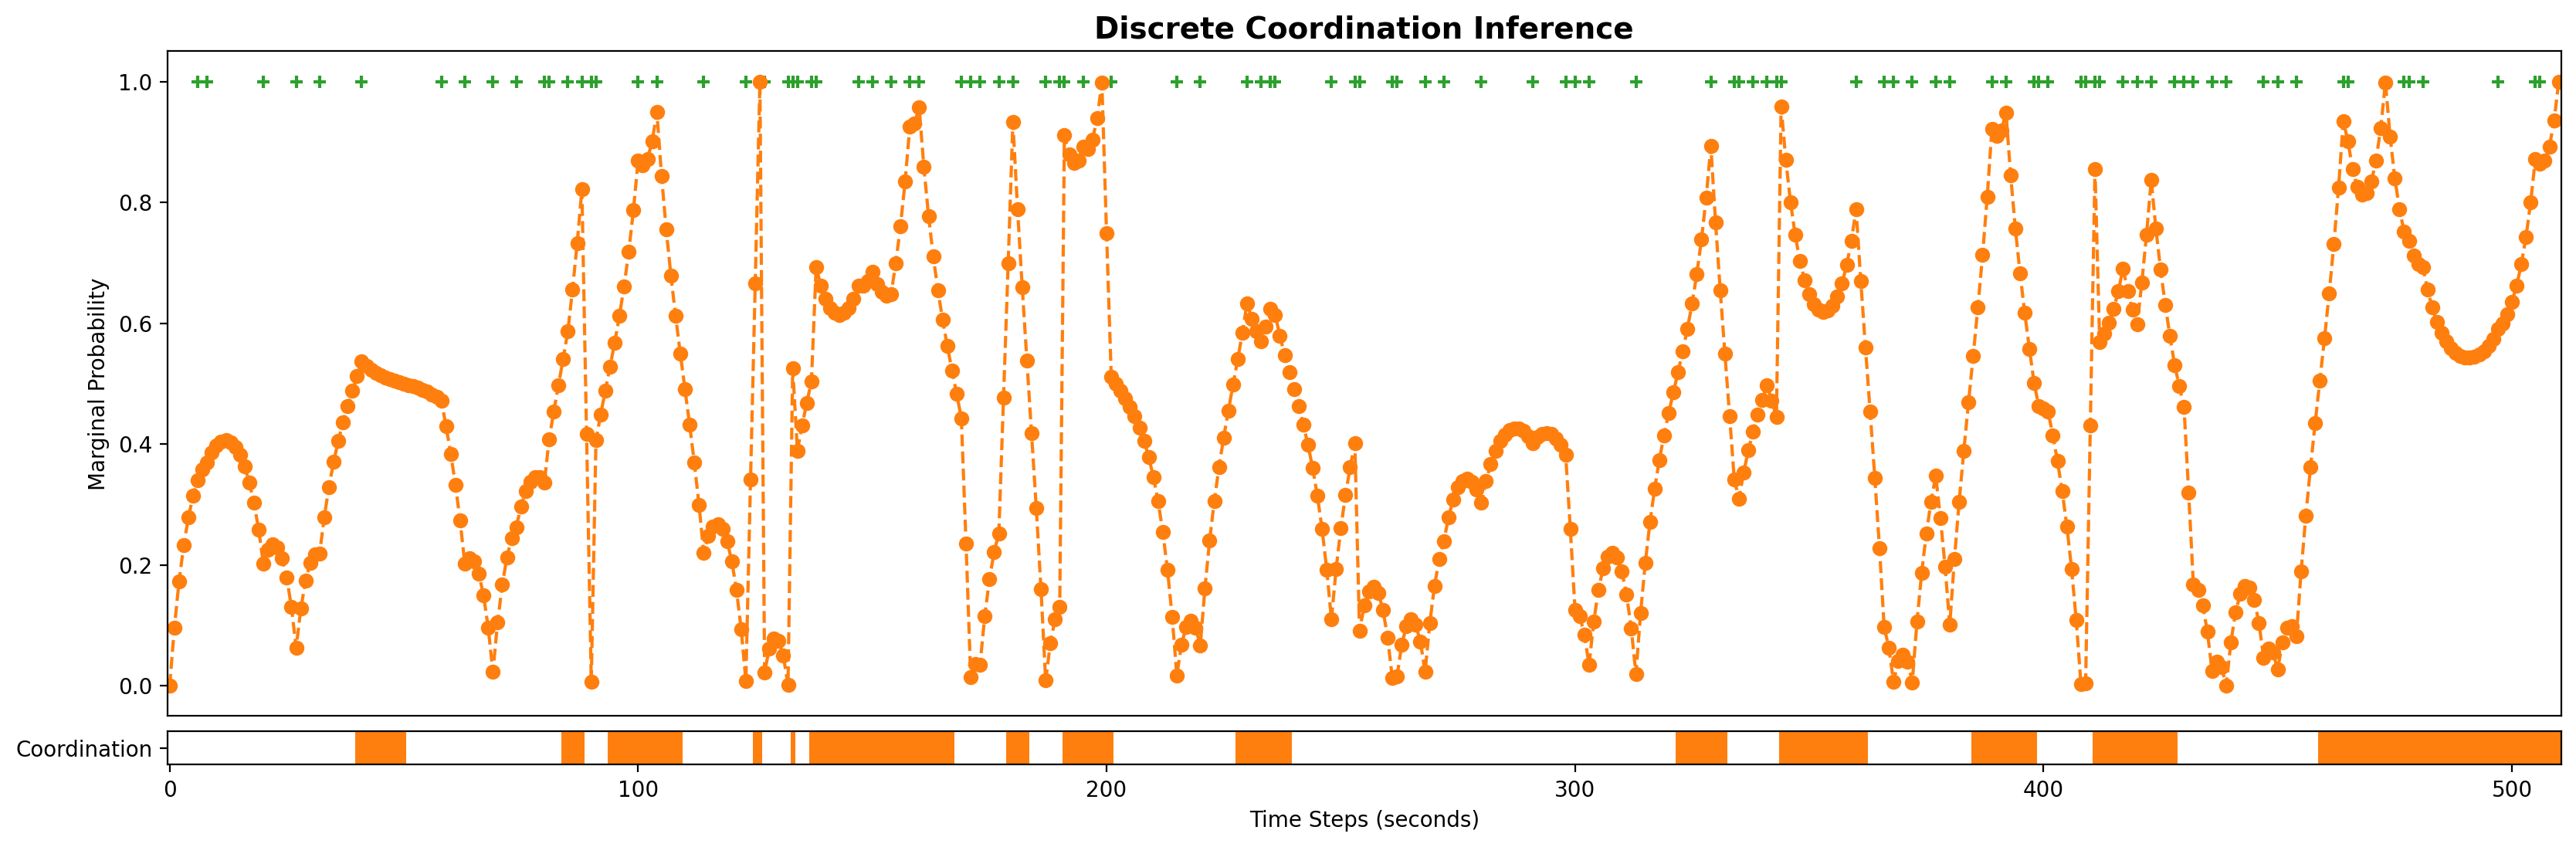

In [10]:
inference_engine = DiscreteCoordinationInferenceFromVocalics(vocalic_series=vocalic_series, 
                                                             p_prior_coordination=P_COORDINATION, 
                                                             p_coordination_transition=P_COORDINATION_TRANSITION,
                                                             mean_prior_vocalics=MEAN_PRIOR_VOCALICS,
                                                             std_prior_vocalics=STD_PRIOR_VOCALICS,
                                                             std_uncoordinated_vocalics=STD_UNCOORDINATED_VOCALICS,
                                                             std_coordinated_vocalics=STD_COORDINATED_VOCALICS)
marginal_cs = inference_engine.estimate_marginals()[1]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:orange", linestyle="--")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Marginal Probability")
plt.title("Discrete Coordination Inference", fontsize=14, weight="bold")
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(vocalic_series.mask) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(marginal_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])

### Anti-Phase Coordination

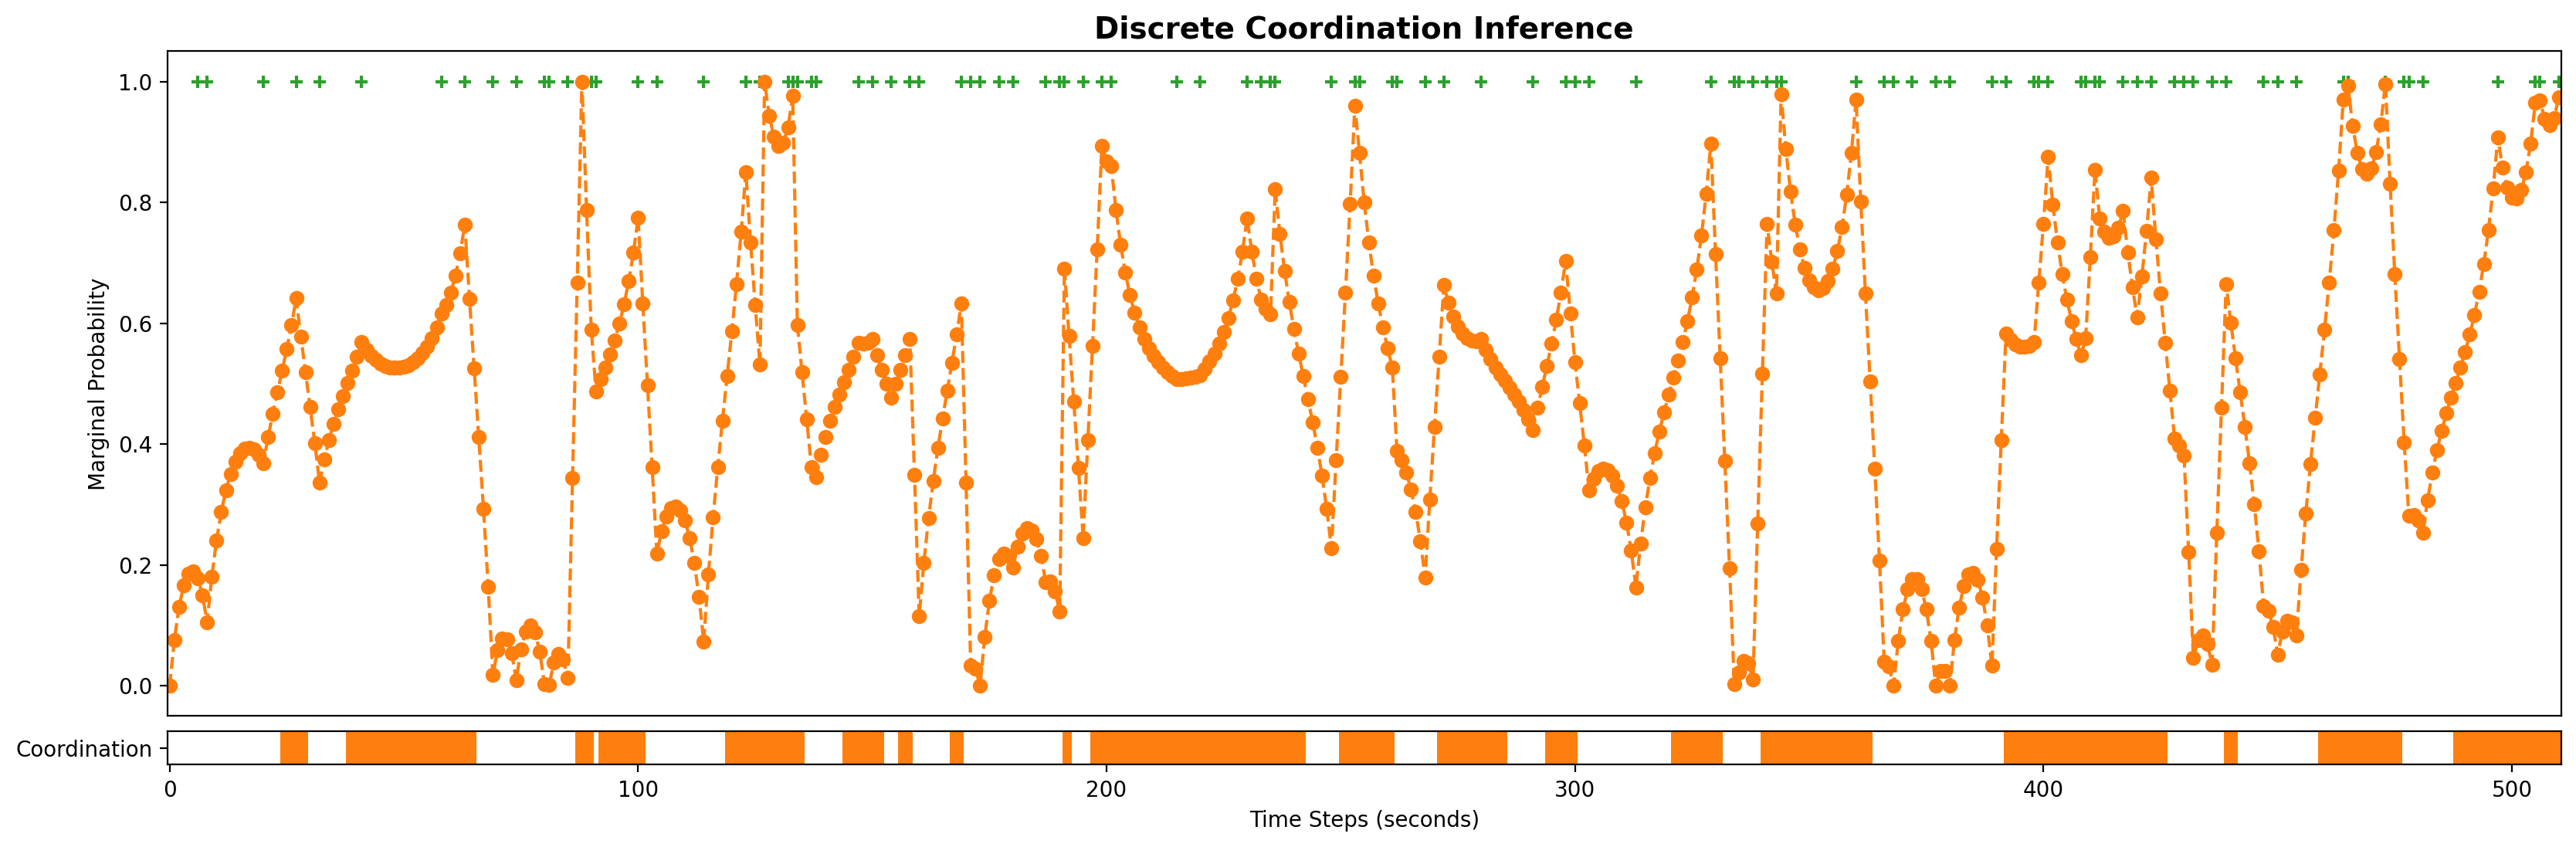

In [11]:
inference_engine = DiscreteCoordinationInferenceFromVocalics(vocalic_series=vocalic_series, 
                                                             p_prior_coordination=P_COORDINATION, 
                                                             p_coordination_transition=P_COORDINATION_TRANSITION,
                                                             mean_prior_vocalics=MEAN_PRIOR_VOCALICS,
                                                             std_prior_vocalics=STD_PRIOR_VOCALICS,
                                                             std_uncoordinated_vocalics=STD_UNCOORDINATED_VOCALICS,
                                                             std_coordinated_vocalics=STD_COORDINATED_VOCALICS,
                                                             f=ANTIPHASE_FUNCTION)
marginal_cs = inference_engine.estimate_marginals()[1]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:orange", linestyle="--")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Marginal Probability")
plt.title("Discrete Coordination Inference", fontsize=14, weight="bold")
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(vocalic_series.mask) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(marginal_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])

### Either-Phase Coordination

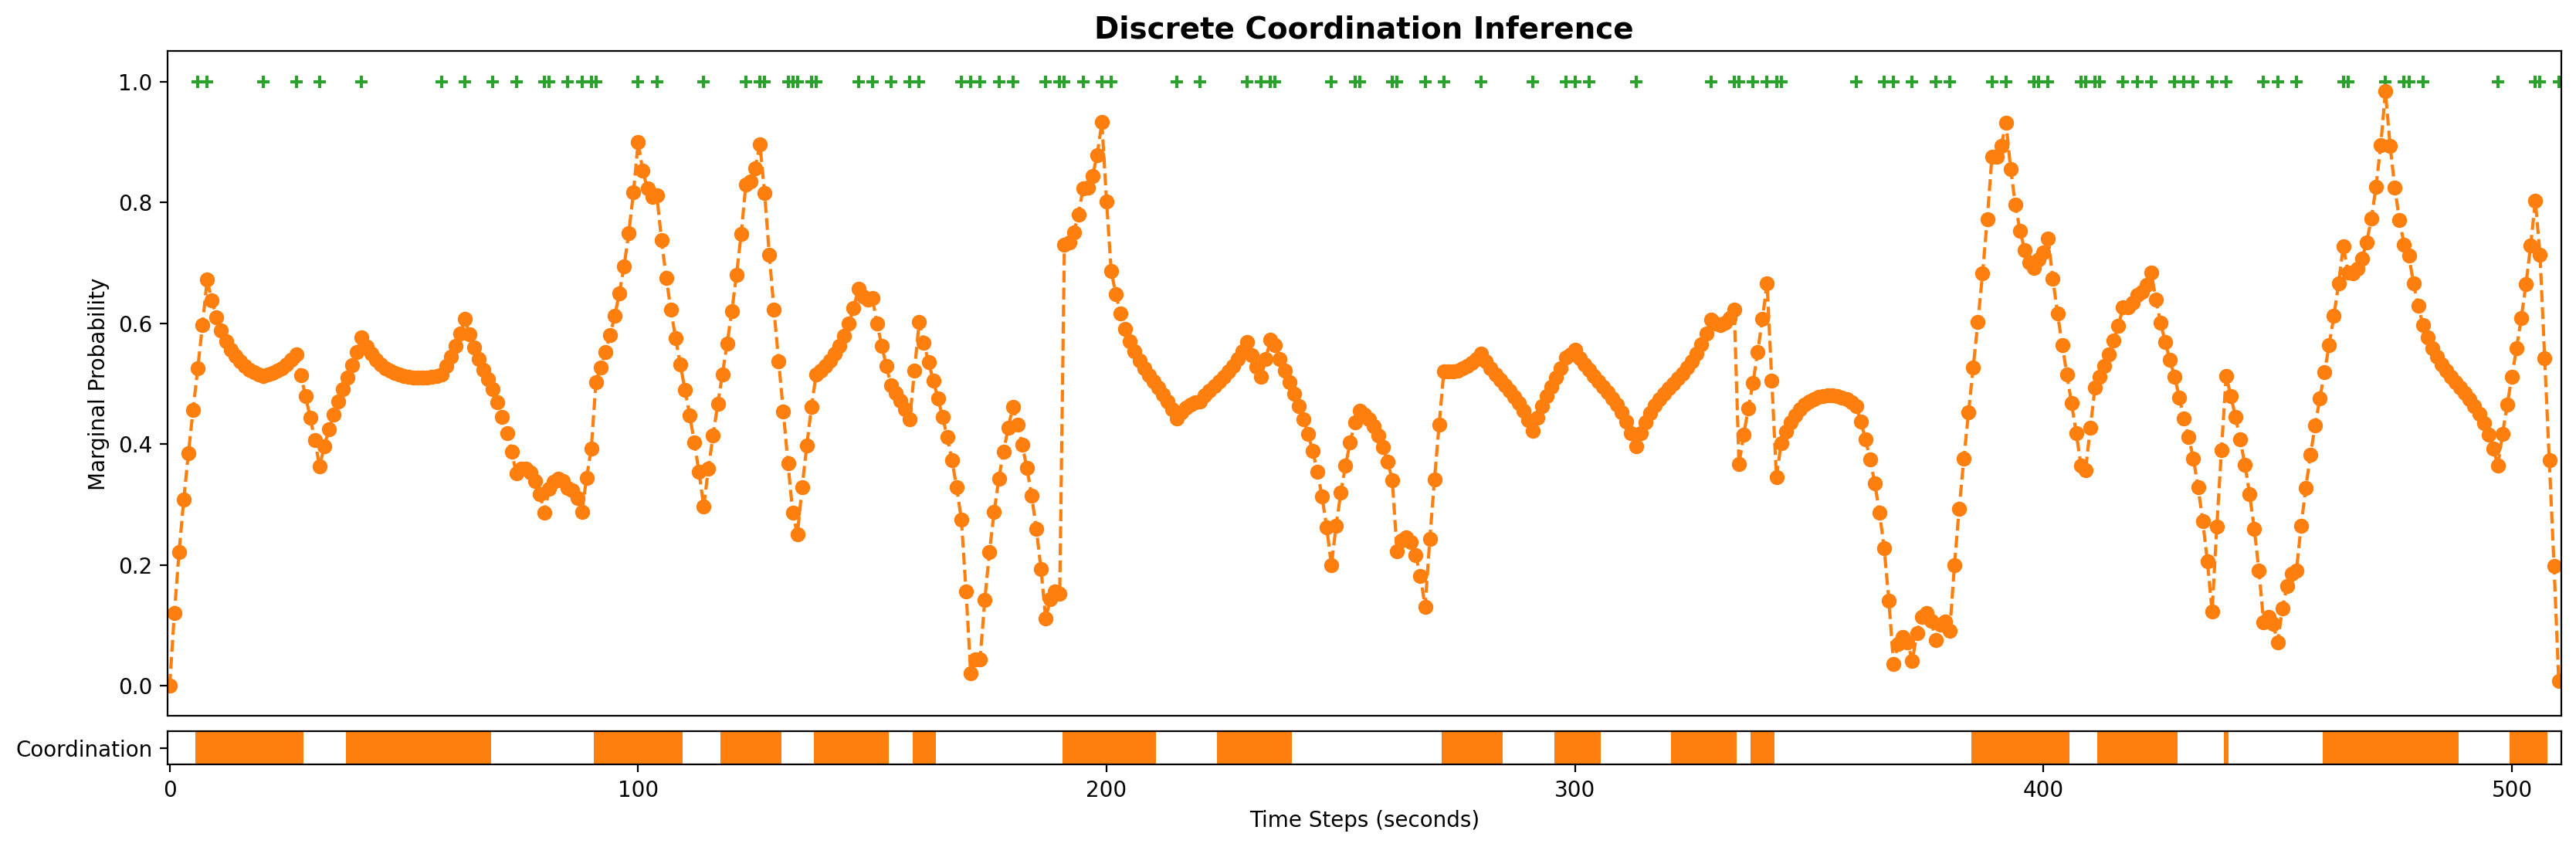

In [12]:
inference_engine = DiscreteCoordinationInferenceFromVocalics(vocalic_series=vocalic_series, 
                                                             p_prior_coordination=P_COORDINATION, 
                                                             p_coordination_transition=P_COORDINATION_TRANSITION,
                                                             mean_prior_vocalics=MEAN_PRIOR_VOCALICS,
                                                             std_prior_vocalics=STD_PRIOR_VOCALICS,
                                                             std_uncoordinated_vocalics=STD_UNCOORDINATED_VOCALICS,
                                                             std_coordinated_vocalics=STD_COORDINATED_VOCALICS,
                                                             f=EITHER_PHASE_FUNCTION)
marginal_cs = inference_engine.estimate_marginals()[1]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), marginal_cs, marker="o", color="tab:orange", linestyle="--")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Marginal Probability")
plt.title("Discrete Coordination Inference", fontsize=14, weight="bold")
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(vocalic_series.mask) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(marginal_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])

## Gaussian Coordination Inference

### Phase Coordination

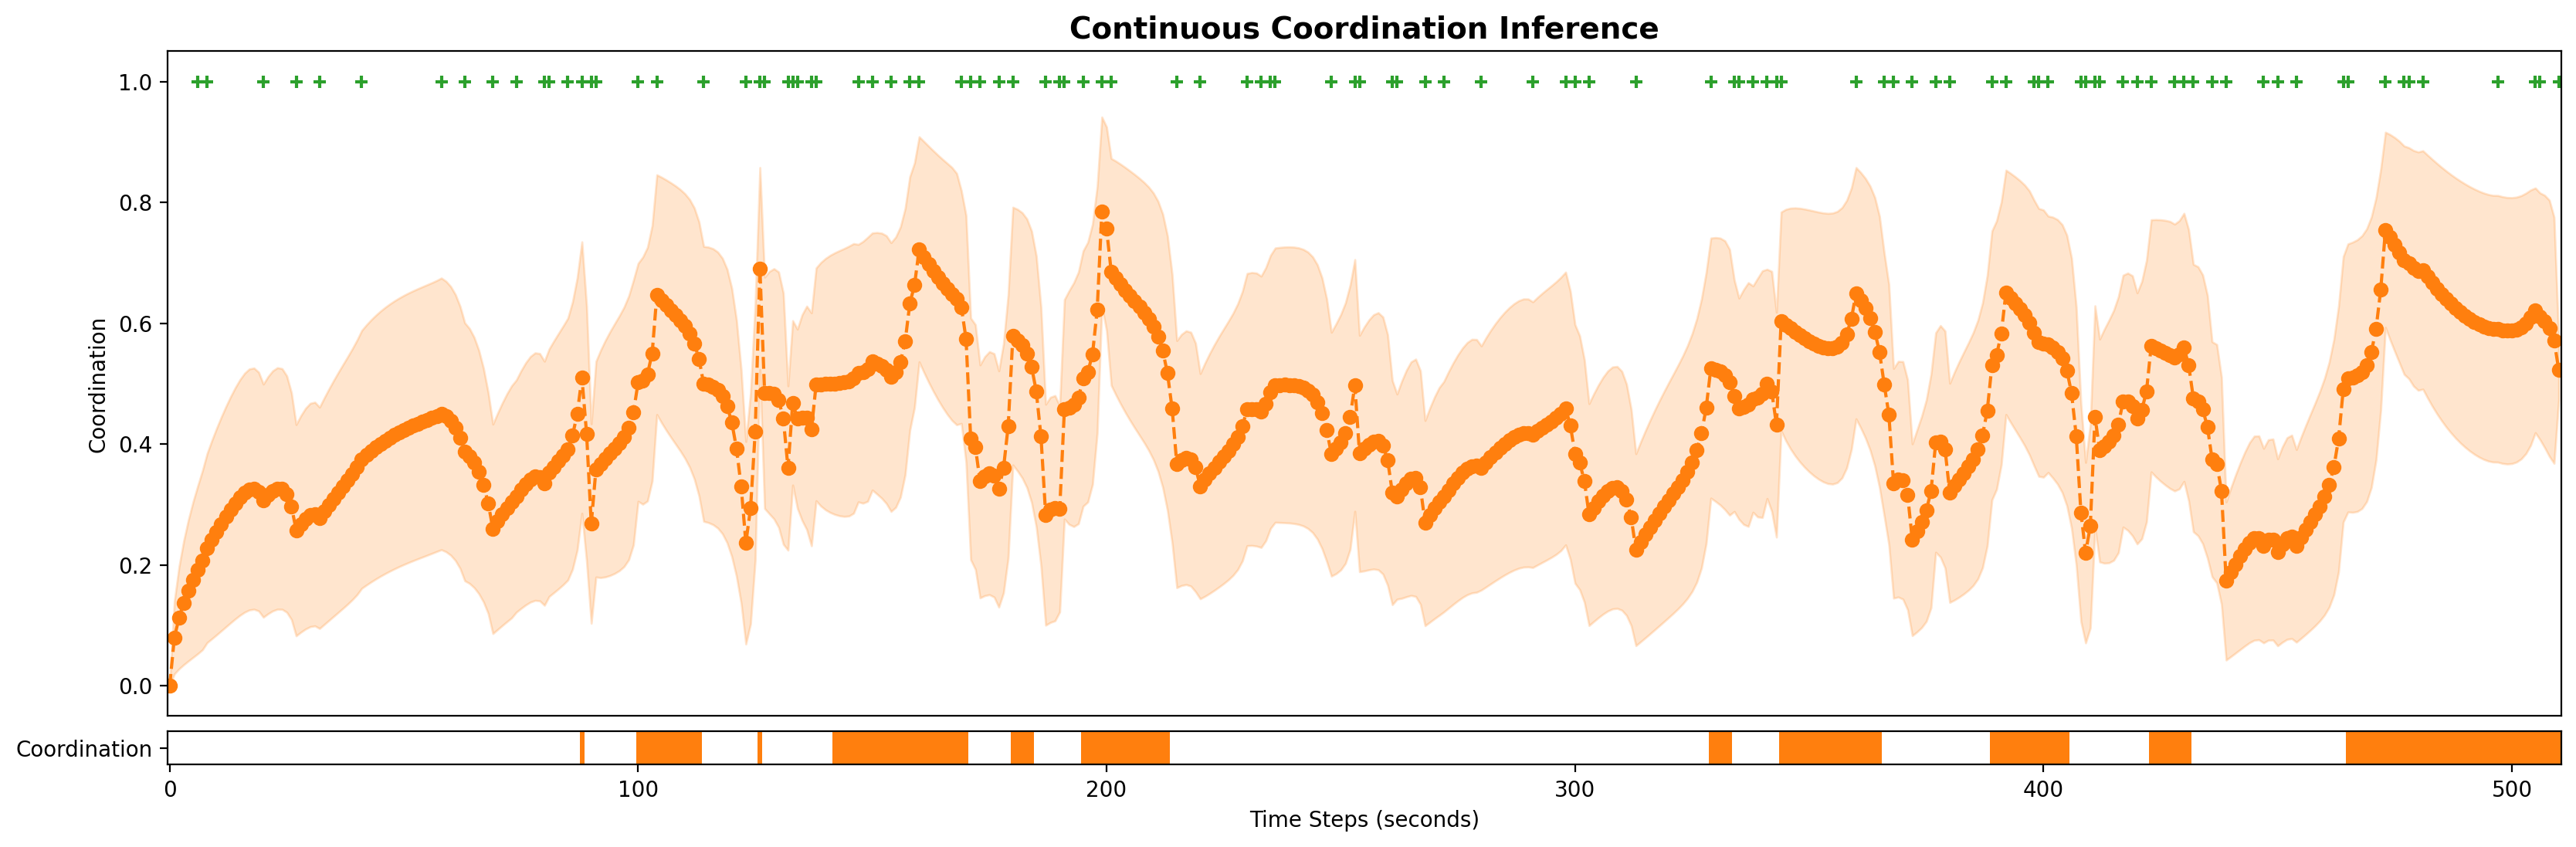

In [14]:
inference_engine = GaussianCoordinationInferenceFromVocalics(vocalic_series=vocalic_series,
                                                               mean_prior_coordination=MEAN_COORDINATION_PRIOR,
                                                               std_prior_coordination=STD_COORDINATION_PRIOR, 
                                                               std_coordination_drifting=STD_COORDINATION_DRIFT,
                                                               mean_prior_vocalics=MEAN_PRIOR_VOCALICS,
                                                               std_prior_vocalics=STD_PRIOR_VOCALICS,
                                                               std_coordinated_vocalics=STD_COORDINATED_VOCALICS)
params = inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(vocalic_series.mask) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination")
plt.title("Continuous Coordination Inference", fontsize=14, weight="bold")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(mean_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])

#### Coordination Change Report

In [9]:
trial_audio = TrialAudio(trial.metadata, "/Users/paulosoares/data/study-3_2022/audio")
report = CoordinationChangeReport(mean_cs, vocalic_series, trial_audio, "Trial: T00045")
report.export_to_html("../data/study-3_2022/T000745/coordination_change/continuous_in_phase_report.html", 0.25)

### Anti-Phase Coordination

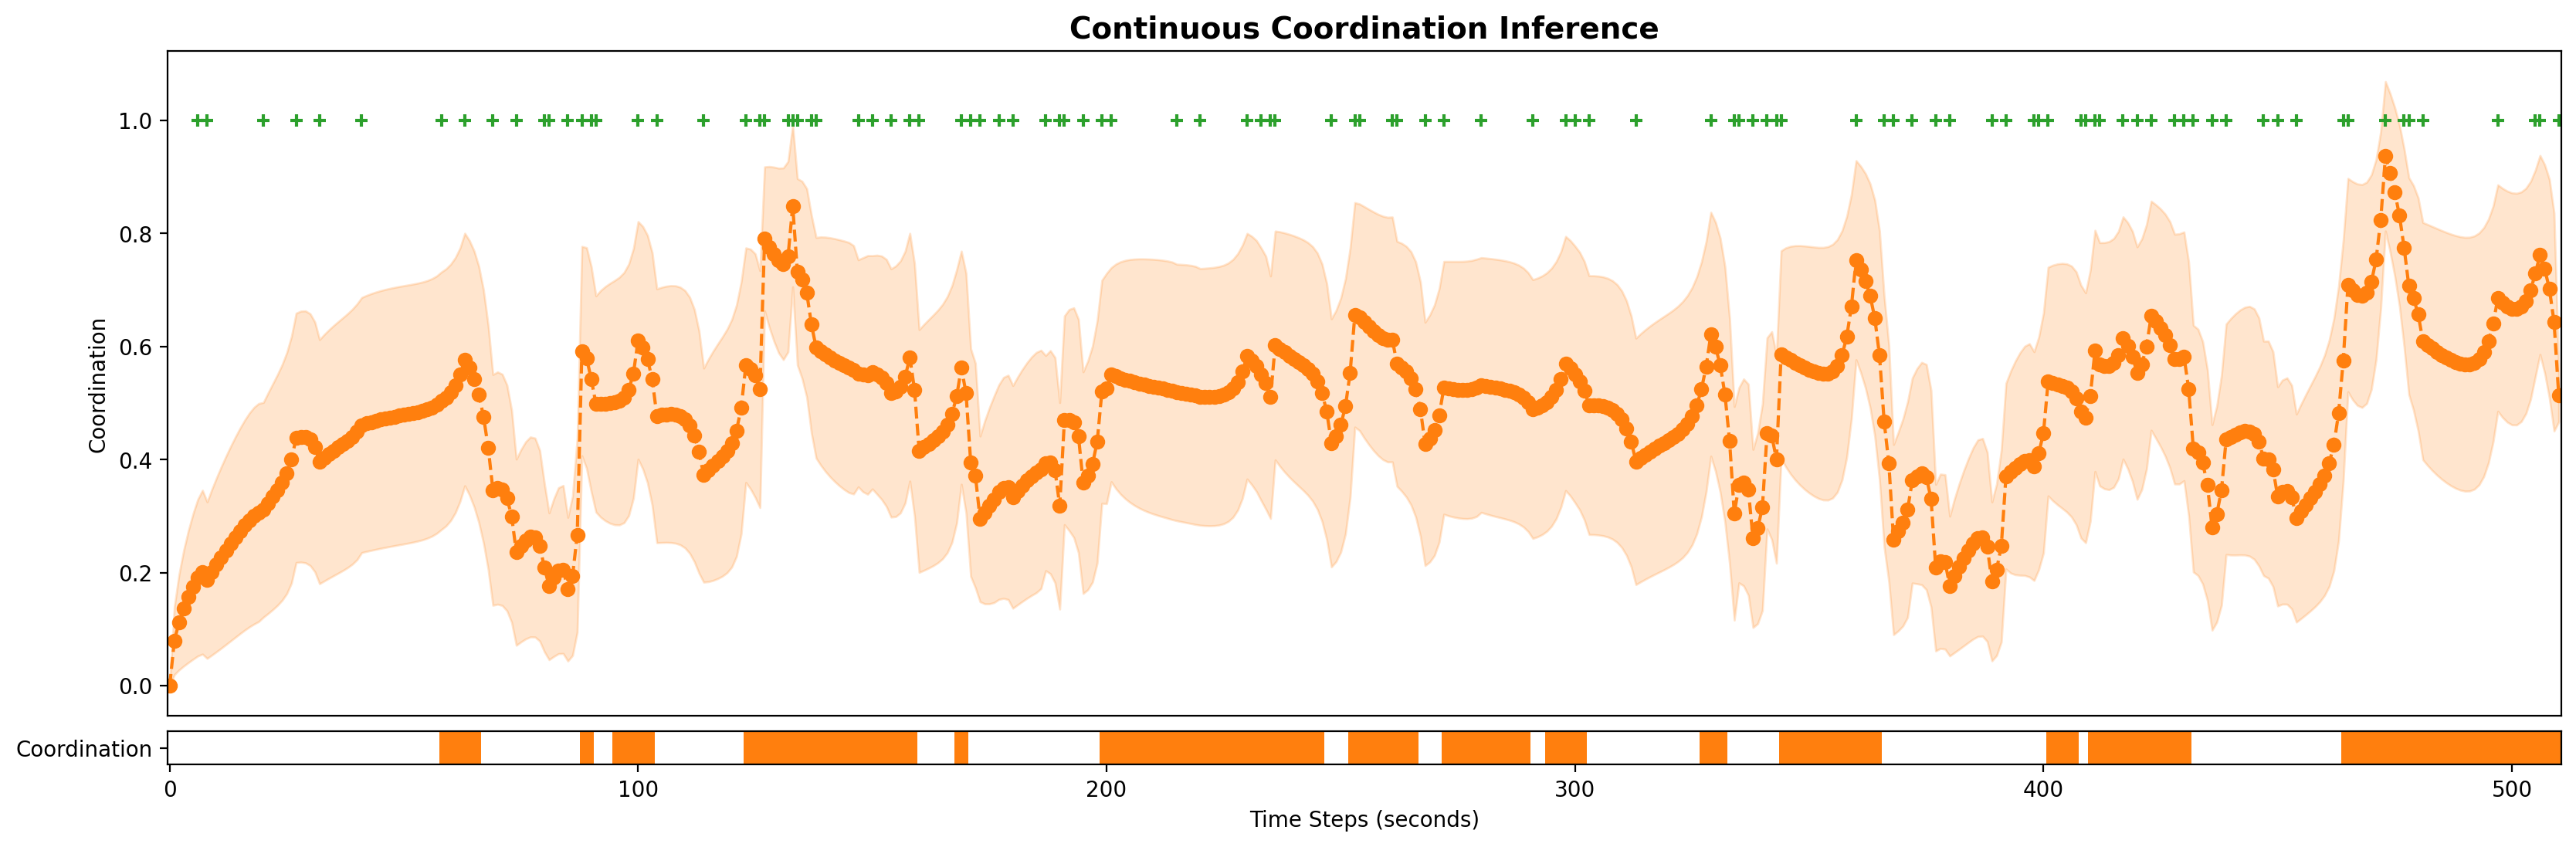

In [15]:
inference_engine = GaussianCoordinationInferenceFromVocalics(vocalic_series=vocalic_series,
                                                               mean_prior_coordination=MEAN_COORDINATION_PRIOR,
                                                               std_prior_coordination=STD_COORDINATION_PRIOR, 
                                                               std_coordination_drifting=STD_COORDINATION_DRIFT,
                                                               mean_prior_vocalics=MEAN_PRIOR_VOCALICS,
                                                               std_prior_vocalics=STD_PRIOR_VOCALICS,
                                                               std_coordinated_vocalics=STD_COORDINATED_VOCALICS,
                                                               f=ANTIPHASE_FUNCTION)
params = inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(vocalic_series.mask) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination")
plt.title("Continuous Coordination Inference", fontsize=14, weight="bold")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(mean_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])

### Either-phase Coordination

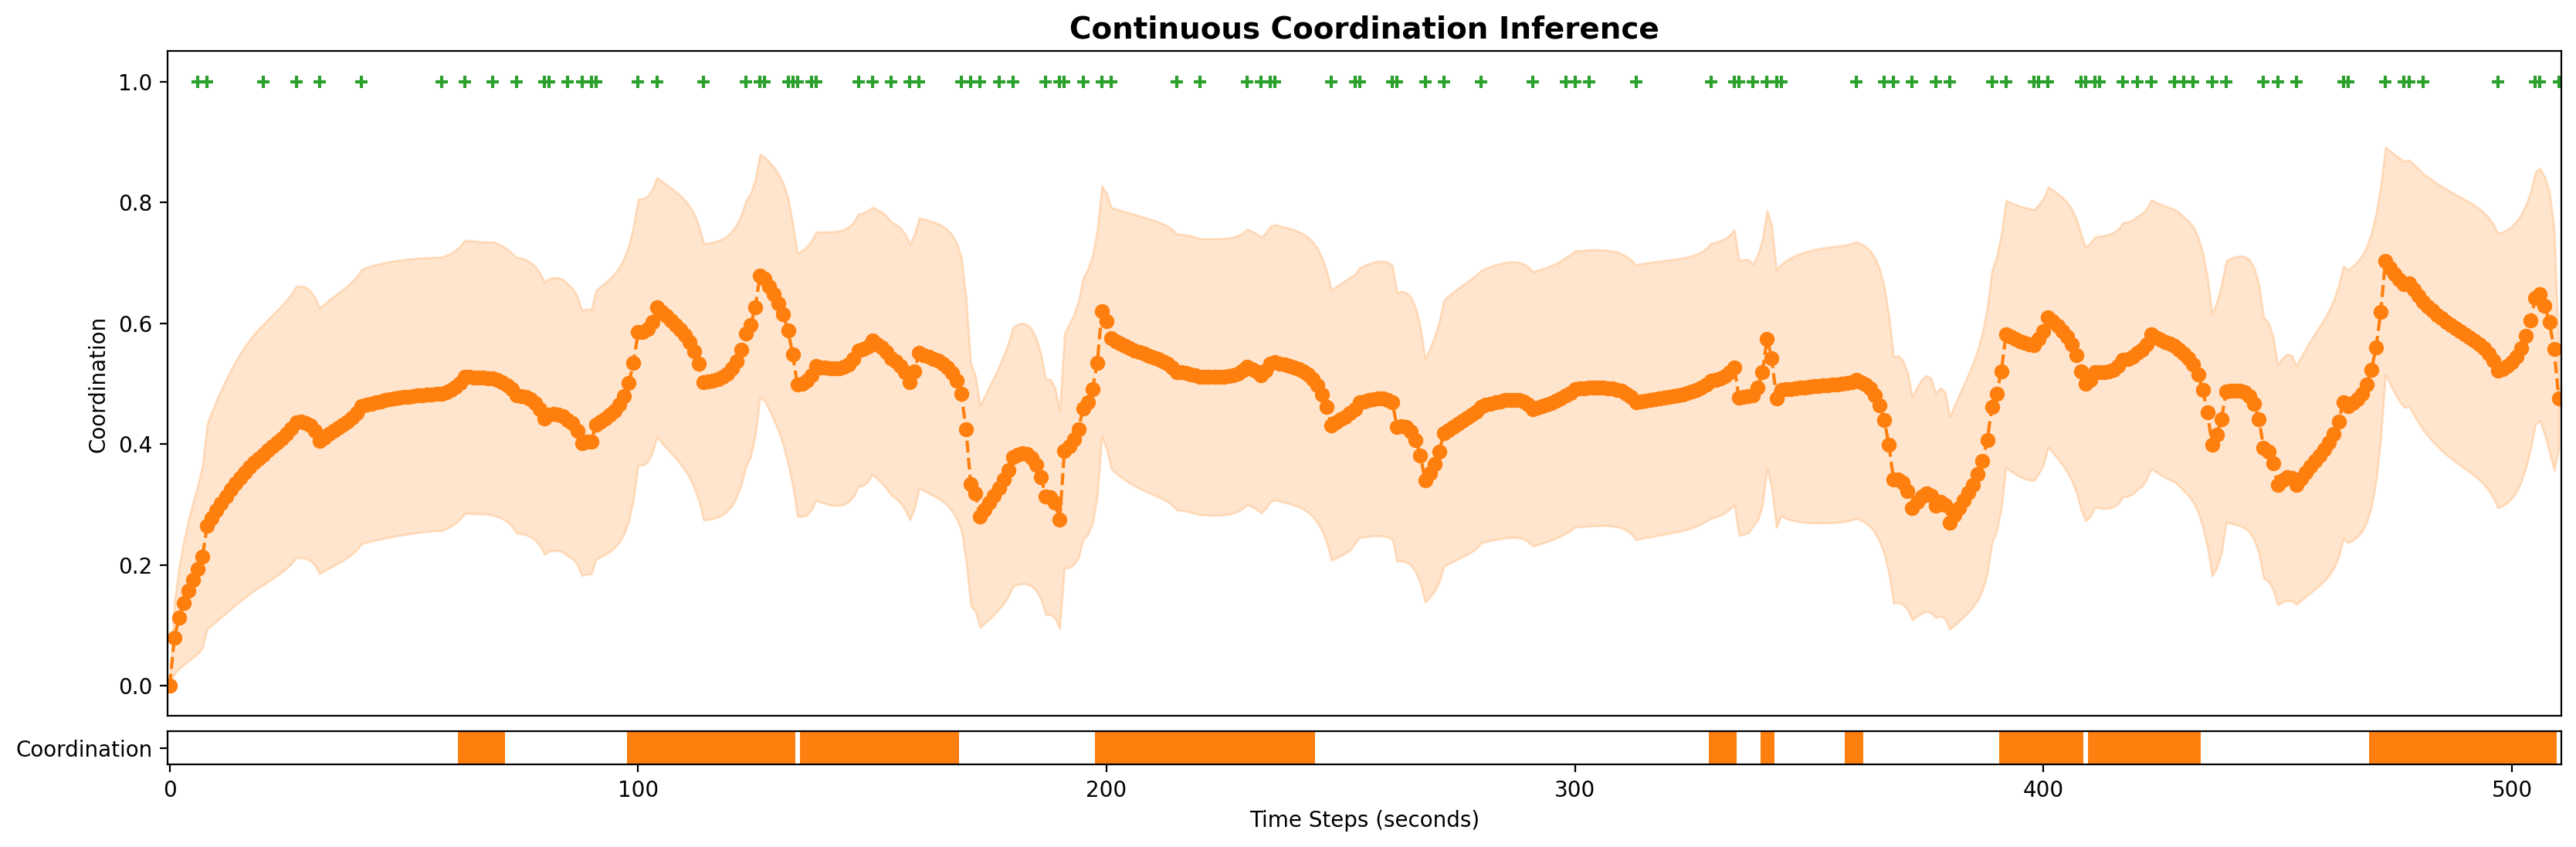

In [16]:
inference_engine = GaussianCoordinationInferenceFromVocalics(vocalic_series=vocalic_series,
                                                               mean_prior_coordination=MEAN_COORDINATION_PRIOR,
                                                               std_prior_coordination=STD_COORDINATION_PRIOR, 
                                                               std_coordination_drifting=STD_COORDINATION_DRIFT,
                                                               mean_prior_vocalics=MEAN_PRIOR_VOCALICS,
                                                               std_prior_vocalics=STD_PRIOR_VOCALICS,
                                                               std_coordinated_vocalics=STD_COORDINATED_VOCALICS,
                                                               f=EITHER_PHASE_FUNCTION)
params = inference_engine.estimate_means_and_variances()
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(vocalic_series.mask) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination")
plt.title("Continuous Coordination Inference", fontsize=14, weight="bold")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(mean_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])

## Beta Coordination Inference

### Phase Coordination

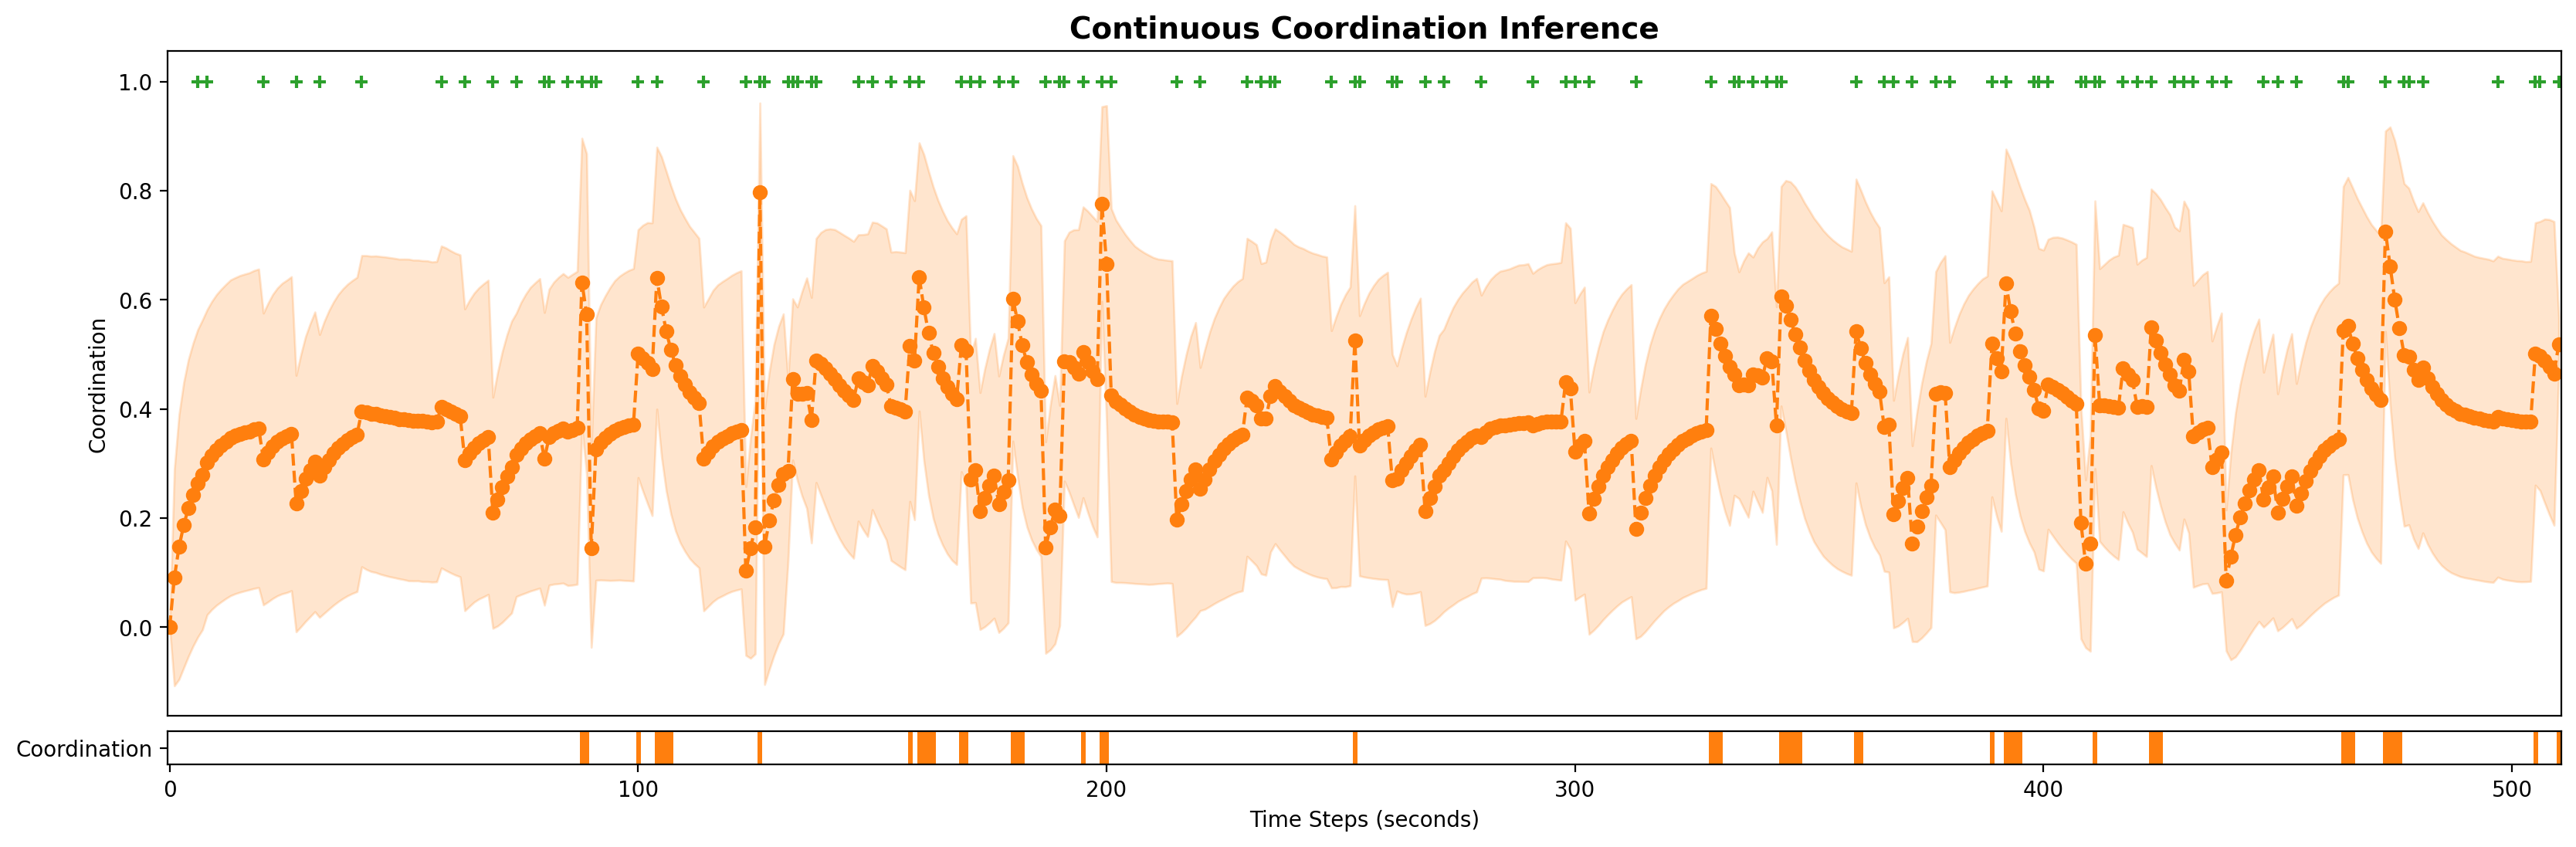

In [18]:
inference_engine = BetaCoordinationInferenceFromVocalics(vocalic_series=vocalic_series,
                                                               prior_a=A0,
                                                               prior_b=B0, 
                                                               std_coordination_drifting=STD_COORDINATION_DRIFT,
                                                               mean_prior_vocalics=MEAN_PRIOR_VOCALICS,
                                                               std_prior_vocalics=STD_PRIOR_VOCALICS,
                                                               std_coordinated_vocalics=STD_COORDINATED_VOCALICS,
                                                               num_particles=100000)
params = inference_engine.estimate_means_and_variances(0)
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(vocalic_series.mask) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination")
plt.title("Continuous Coordination Inference", fontsize=14, weight="bold")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(mean_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])

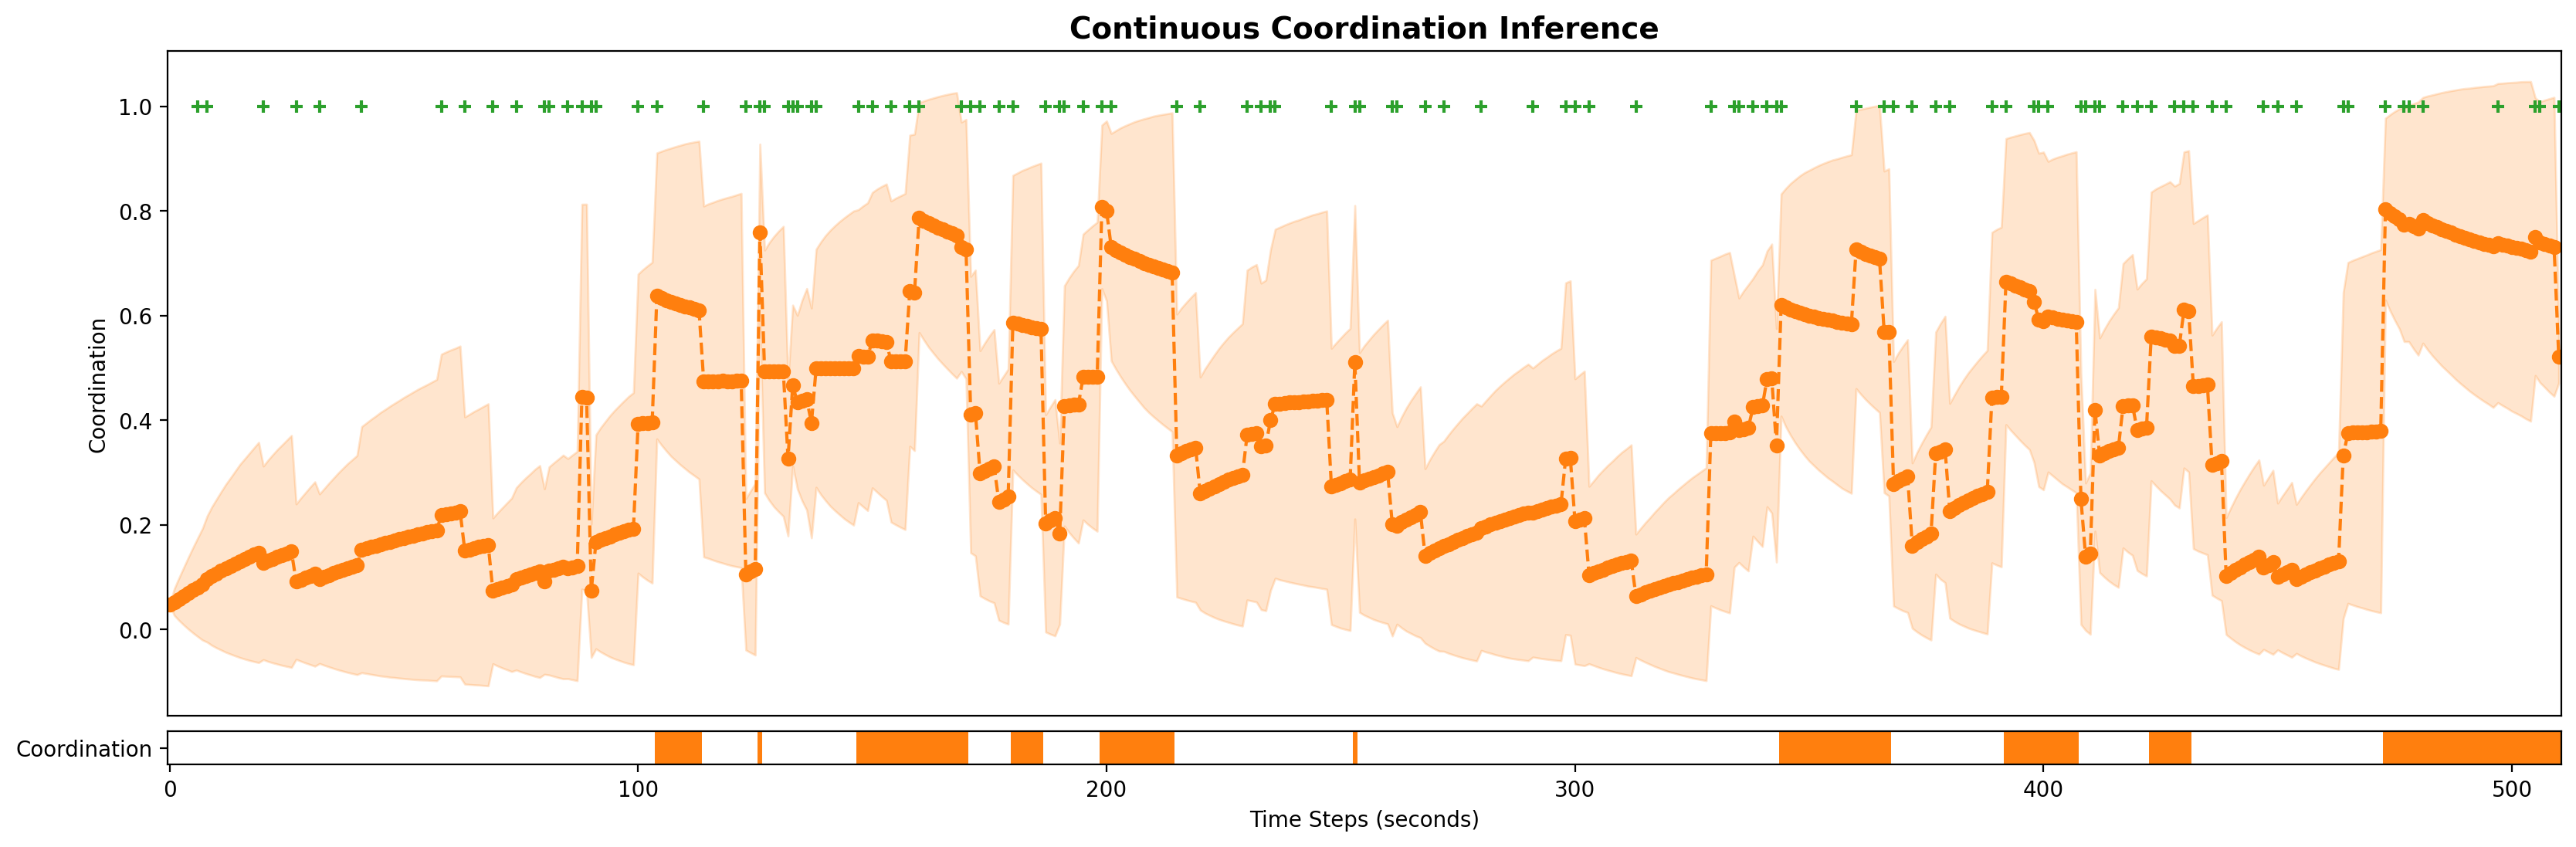

In [21]:
inference_engine = LogisticCoordinationInferenceFromVocalics(vocalic_series=vocalic_series,                                                               
                                                             std_coordination_drifting=0.5,
                                                             mean_prior_vocalics=MEAN_PRIOR_VOCALICS,
                                                             std_prior_vocalics=STD_PRIOR_VOCALICS,
                                                             std_coordinated_vocalics=STD_COORDINATED_VOCALICS,
                                                             num_particles=100000)
params = inference_engine.estimate_means_and_variances(0)
mean_cs = params[0]; var_cs = params[1]
fig = plt.figure(figsize=(20, 6))
plt.plot(range(M+1), mean_cs, marker="o", color="tab:orange", linestyle="--")
plt.fill_between(range(M+1), mean_cs - np.sqrt(var_cs), mean_cs + np.sqrt(var_cs), color='tab:orange', alpha=0.2)
times, masks = list(zip(*[(t, mask) for t, mask in enumerate(vocalic_series.mask) if mask > 0 and t <= M]))
plt.scatter(times, masks, color="tab:green", marker="+")
plt.xlabel("Time Steps (seconds)")
plt.ylabel("Coordination")
plt.title("Continuous Coordination Inference", fontsize=14, weight="bold")
add_discrete_coordination_bar(main_ax=fig.gca(),
                              coordination_series=[np.where(mean_cs > 0.5, 1, 0)],
                              coordination_colors=["tab:orange"],
                              labels=["Coordination"])